## Threshold for condition:
We want to decide wether a problem is unique or non unique depending on this threshold.

### Non uniqueness

 We choose the threshoold $T$ as 
 $$T = \frac{\tilde{\sigma}_1}{\sqrt{E}} $$
where $E = m(C_m \frac{\epsilon}{h} + h^{order} M C_a)^2 + \|u-\tilde{u}\|_2^2$ and $\epsilon = \|u-u_{noise}\|_{\infty} + 10^{-16}$ and $h=dx$. If a value is bigger than T the function u should be nonunique.

In [1]:
import numpy as np
from numpy.linalg import matrix_rank, svd
from test_data import experiment_data,add_noise,create_data_2d
import pysindy as ps
import matplotlib.pyplot as plt

In [117]:
"""
n: number of data points used for approximation/ order
k: number of lagrange coefficient
l: input to lagrange coefficient: x = x_l = x+ hl
"""
#Computes the coefficients of the derivitve of the kth Lagrangian Coefficients
#These are also the coefficients used for finite differences
def lagrange_coefficient_derivative(n,k,l):
    erg=0.0        
    for j in range(n+1):
        if j!=k:
            tmp =1.0
            for i in range(n+1):
                  if i!=k and i!=j:
                    tmp *=(l-i)/(k-i)
                    #print(f"l-k = {l}-{i}")
            tmp*=1.0/(k-j)
            erg+=tmp
    return erg
    
#Sums up the above coefficients
#needed for measurment error
def sum_lagrange_coefficient_derivative(n,l):
    erg=0.0
    for k in range(n+1):
        #print(f"L({n},{k},{l}) = {lagrange_coefficient_derivative(n,k,l)}")
        erg+= np.abs(lagrange_coefficient_derivative(n,k,l))
    return erg

# Approximation error central differences: reduces with higher order n
def appr_error_central_diff(n):
    assert(n%2==0) #Check if n is even
    bound = (np.math.factorial(int(n/2))**2)/np.math.factorial(n+1)
    return bound
    
# Approximation error backward differences: reduces with higher order n
def appr_error_backward_diff(n):
    return 1/(n+1)

# Measurement error central differences
def meas_error_central_diff(n):
    assert(n%2==0) #Check if n is even
    erg=sum_lagrange_coefficient_derivative(n,n/2)
    return erg
    
# Measurement error backward differences
def meas_error_backward_diff(n):
    erg=sum_lagrange_coefficient_derivative(n,0)
    return erg



"""
eps: measurement error+round of error (Does it make sense to add machine precision?)
h: dx for equispaced data
M: bound on (order+1)th derivative
"""
def error_bound(eps,h,M,order=2):
    eps+=np.finfo(float).eps # add machine precisoin
    if order%2==0: #even order
        C_app=appr_error_central_diff(order)
        C_meas=meas_error_central_diff(order)
    else: # odd order
        C_app=appr_error_backward_diff(order)
        C_meas=meas_error_backward_diff(order)
    #print(f" C_meas*eps/h + (h**order)*M*C_app = {C_meas:2.3e}*{eps:2.3e}/{h:2.3e} + {h**order:2.3e}*{M:2.3e}*{C_app:2.3e}")    
    return C_meas*eps/h + (h**order)*M*C_app
            
def infinity_norm(x):
    return np.max(np.abs(x))

"""
eps_two: ||u-u_noise||_2 two norm
eps_infty: ||u-u_noise||_infty infinity norm
h: dx for equispaced data
number_datapoints: number of total datapoints where u is evaluated
M: bound on nth derivative depending on the order
"""
def error_bound_g(eps_two,eps_infty,h,number_datapoints,M,order):
    E = eps_two**2 + number_datapoints*error_bound(eps_infty,h,M,order)**2
    return E


In [128]:
def calc_threshold(eps,h,number_datapoints,order=2):
    eps+=np.finfo(float).eps # add machine precisoin
    if order%2==0: #even order
        C_meas=meas_error_central_diff(order)
    else: # odd order
        C_meas=meas_error_backward_diff(order)
    return 1/(eps/h+h**order)

def calc_threshold2(omax,eps_two,eps_infty,h,number_datapoints,M,order=2): 
    E = error_bound_g(eps_two,eps_infty,h,number_datapoints,M,order)
    return omax/np.sqrt(E)

In [129]:
n_samples=50
T,X,t,x = create_data_2d(T_start=-5, T_end=1, L_x_start=0,L_x_end=1, N_t=n_samples, N_x=n_samples)
a=np.random.randn()

u = np.exp(X-a*T)
ux = u
uxx = u
uxxx = u
ut = -a*u

dx=x[1]-x[0]

In [130]:
u_flat, ux_flat = u.flatten(), ux.flatten()
true_g = np.concatenate([u_flat.reshape(len(u_flat),1), ux_flat.reshape(len(ux_flat),1)], axis=1)
sv = svd(true_g, compute_uv=False)
sv_max,sv_min=sv[0],sv[-1]
print(f"M: {np.max(u)}")
print(f"Singular values of g: {sv_max,sv_min}")
print(f"sv_max/sv_min: {sv_max/sv_min:3.3e}")

M: 42.03404680660467
Singular values of g: (782.1081094912803, 9.305276289822984e-14)
sv_max/sv_min: 8.405e+15


In [131]:
u_flat, ux_flat = u.flatten(), ux.flatten()
true_g = np.concatenate([u_flat.reshape(len(u_flat),1), ux_flat.reshape(len(ux_flat),1)], axis=1)
sv = svd(true_g, compute_uv=False)
sv_max,sv_min=sv[0],sv[-1]
print(f"M: {np.max(u)}")
print(f"Singular values of g: {sv_max,sv_min}")
print(f"sv_max/sv_min: {sv_max/sv_min:3.3e}")

M: 42.03404680660467
Singular values of g: (782.1081094912803, 9.305276289822984e-14)
sv_max/sv_min: 8.405e+15


True ratio: 8.405e+15
Noise level 	 order 	 	 ratio 	 	 threshold 	 threshold2
0
0.0
	  	 2 	 	 4.352e+04 	 2.401e+03 	 5.361e+03
	  	 3 	 	 4.214e+06 	 1.176e+05 	 1.751e+05
	  	 4 	 	 2.803e+08 	 5.765e+06 	 6.436e+07
	  	 5 	 	 1.416e+10 	 2.825e+08 	 6.307e+08
	  	 6 	 	 8.477e+11 	 1.384e+10 	 7.204e+11
	  	 7 	 	 5.071e+13 	 6.733e+11 	 1.897e+12
	  	 8 	 	 4.761e+13 	 2.441e+13 	 6.339e+14
	  	 9 	 	 2.893e+13 	 8.700e+13 	 1.064e+13


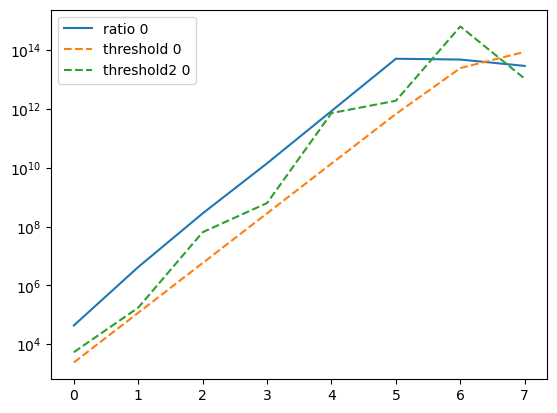

Noise level 	 order 	 	 ratio 	 	 threshold 	 threshold2
1e-10
5.5741208010743716e-08
	  	 2 	 	 4.352e+04 	 2.400e+03 	 5.361e+03
	  	 3 	 	 4.210e+06 	 1.144e+05 	 1.720e+05
	  	 4 	 	 1.959e+08 	 2.408e+06 	 2.583e+07
	  	 5 	 	 1.954e+08 	 4.077e+06 	 3.769e+06
	  	 6 	 	 1.422e+08 	 4.135e+06 	 3.529e+07
	  	 7 	 	 9.275e+07 	 4.137e+06 	 1.406e+06
	  	 8 	 	 5.876e+07 	 4.137e+06 	 3.106e+07
	  	 9 	 	 3.586e+07 	 4.137e+06 	 4.796e+05


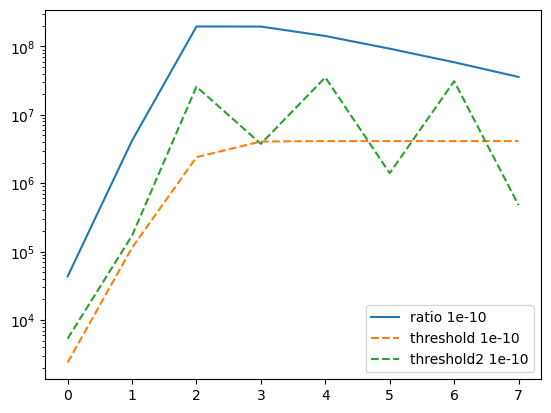

Noise level 	 order 	 	 ratio 	 	 threshold 	 threshold2
1e-09
5.51501638827737e-07
	  	 2 	 	 4.352e+04 	 2.391e+03 	 5.358e+03
	  	 3 	 	 4.175e+06 	 9.694e+04 	 1.542e+05
	  	 4 	 	 2.633e+07 	 5.027e+05 	 5.272e+06
	  	 5 	 	 1.912e+07 	 5.496e+05 	 5.043e+05
	  	 6 	 	 1.425e+07 	 5.506e+05 	 4.698e+06
	  	 7 	 	 9.567e+06 	 5.507e+05 	 1.872e+05
	  	 8 	 	 6.135e+06 	 5.507e+05 	 4.135e+06
	  	 9 	 	 3.733e+06 	 5.507e+05 	 6.385e+04


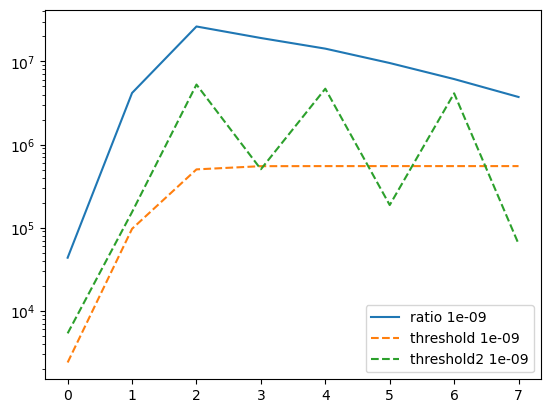

Noise level 	 order 	 	 ratio 	 	 threshold 	 threshold2
1e-08
5.568549627262164e-06
	  	 2 	 	 4.352e+04 	 2.268e+03 	 5.317e+03
	  	 3 	 	 2.366e+06 	 3.039e+04 	 6.207e+04
	  	 4 	 	 2.717e+06 	 4.069e+04 	 4.245e+05
	  	 5 	 	 1.973e+06 	 4.098e+04 	 3.756e+04
	  	 6 	 	 1.472e+06 	 4.098e+04 	 3.497e+05
	  	 7 	 	 9.583e+05 	 4.098e+04 	 1.393e+04
	  	 8 	 	 5.863e+05 	 4.098e+04 	 3.077e+05
	  	 9 	 	 3.411e+05 	 4.098e+04 	 4.752e+03


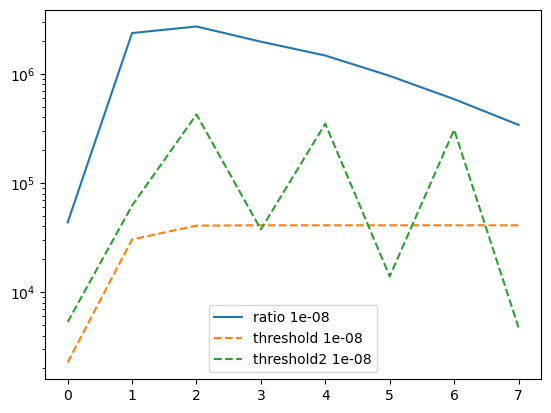

Noise level 	 order 	 	 ratio 	 	 threshold 	 threshold2
1e-07
5.533730876934828e-05
	  	 2 	 	 4.331e+04 	 1.588e+03 	 4.996e+03
	  	 3 	 	 2.860e+05 	 4.509e+03 	 1.035e+04
	  	 4 	 	 2.669e+05 	 4.685e+03 	 4.885e+04
	  	 5 	 	 1.988e+05 	 4.688e+03 	 4.297e+03
	  	 6 	 	 1.538e+05 	 4.688e+03 	 4.000e+04
	  	 7 	 	 1.050e+05 	 4.688e+03 	 1.594e+03
	  	 8 	 	 6.683e+04 	 4.688e+03 	 3.520e+04
	  	 9 	 	 3.980e+04 	 4.688e+03 	 5.436e+02


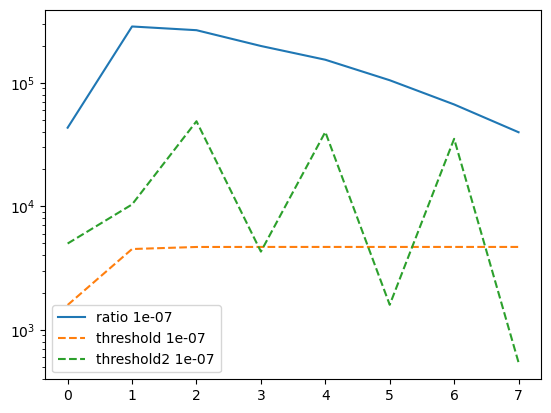

Noise level 	 order 	 	 ratio 	 	 threshold 	 threshold2
1e-06
0.0005453324423915556
	  	 2 	 	 3.428e+04 	 4.368e+02 	 3.265e+03
	  	 3 	 	 3.005e+04 	 5.316e+02 	 1.244e+03
	  	 4 	 	 2.835e+04 	 5.339e+02 	 5.568e+03
	  	 5 	 	 2.024e+04 	 5.340e+02 	 4.894e+02
	  	 6 	 	 1.489e+04 	 5.340e+02 	 4.556e+03
	  	 7 	 	 9.915e+03 	 5.340e+02 	 1.815e+02
	  	 8 	 	 6.380e+03 	 5.340e+02 	 4.009e+03
	  	 9 	 	 3.884e+03 	 5.340e+02 	 6.191e+01


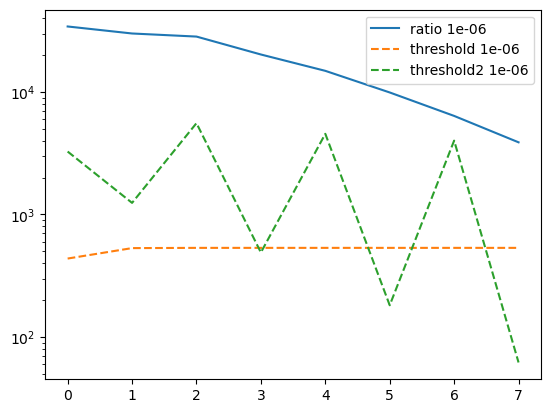

Noise level 	 order 	 	 ratio 	 	 threshold 	 threshold2
1e-05
0.005567373881992078
	  	 2 	 	 4.882e+03 	 5.398e+01 	 7.440e+02
	  	 3 	 	 2.993e+03 	 5.520e+01 	 1.295e+02
	  	 4 	 	 2.832e+03 	 5.522e+01 	 5.759e+02
	  	 5 	 	 1.994e+03 	 5.522e+01 	 5.062e+01
	  	 6 	 	 1.428e+03 	 5.522e+01 	 4.712e+02
	  	 7 	 	 9.137e+02 	 5.522e+01 	 1.877e+01
	  	 8 	 	 5.682e+02 	 5.522e+01 	 4.147e+02
	  	 9 	 	 3.434e+02 	 5.522e+01 	 6.404e+00


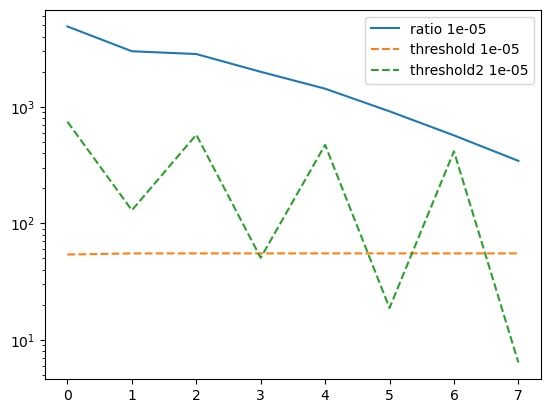

Noise level 	 order 	 	 ratio 	 	 threshold 	 threshold2
0.0001
0.0545531687133191
	  	 2 	 	 4.767e+02 	 5.168e+00 	 7.981e+01
	  	 3 	 	 2.978e+02 	 5.179e+00 	 1.215e+01
	  	 4 	 	 2.782e+02 	 5.179e+00 	 5.401e+01
	  	 5 	 	 1.990e+02 	 5.179e+00 	 4.747e+00
	  	 6 	 	 1.461e+02 	 5.179e+00 	 4.419e+01
	  	 7 	 	 9.675e+01 	 5.179e+00 	 1.760e+00
	  	 8 	 	 6.186e+01 	 5.179e+00 	 3.888e+01
	  	 9 	 	 3.775e+01 	 5.179e+00 	 6.006e-01


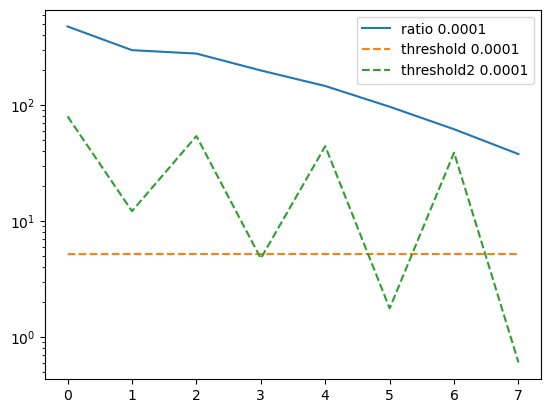

Noise level 	 order 	 	 ratio 	 	 threshold 	 threshold2
0.001
0.5534650276306087
	  	 2 	 	 4.801e+01 	 5.240e-01 	 8.184e+00
	  	 3 	 	 2.970e+01 	 5.241e-01 	 1.230e+00
	  	 4 	 	 2.792e+01 	 5.241e-01 	 5.465e+00
	  	 5 	 	 2.012e+01 	 5.241e-01 	 4.804e-01
	  	 6 	 	 1.501e+01 	 5.241e-01 	 4.473e+00
	  	 7 	 	 1.009e+01 	 5.241e-01 	 1.785e-01
	  	 8 	 	 6.527e+00 	 5.241e-01 	 3.967e+00
	  	 9 	 	 4.075e+00 	 5.241e-01 	 6.255e-02


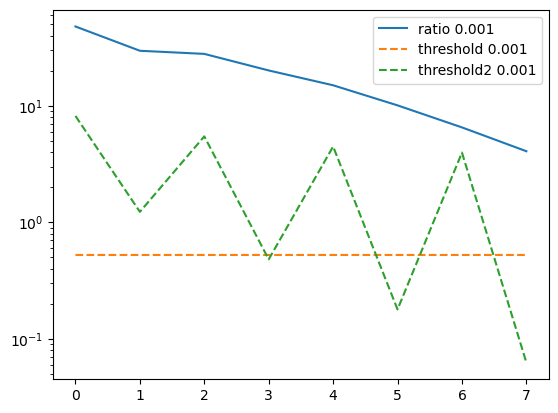

Noise level 	 order 	 	 ratio 	 	 threshold 	 threshold2
0.01
5.407347670024963
	  	 2 	 	 5.234e+00 	 5.548e-02 	 8.863e-01
	  	 3 	 	 3.396e+00 	 5.548e-02 	 1.378e-01
	  	 4 	 	 3.233e+00 	 5.548e-02 	 6.180e-01
	  	 5 	 	 2.617e+00 	 5.548e-02 	 5.816e-02
	  	 6 	 	 2.419e+00 	 5.548e-02 	 6.095e-01
	  	 7 	 	 2.667e+00 	 5.548e-02 	 3.141e-02
	  	 8 	 	 3.585e+00 	 5.548e-02 	 1.006e+00
	  	 9 	 	 5.458e+00 	 5.548e-02 	 2.440e-02


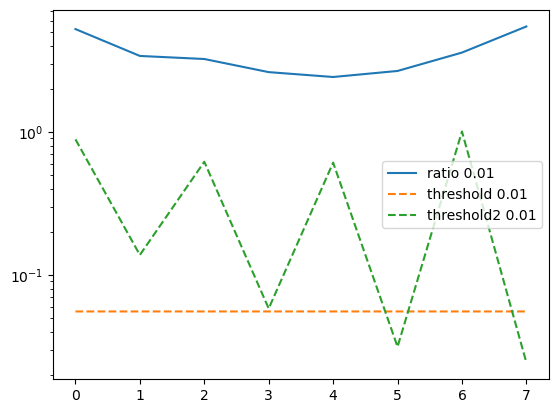

In [133]:
M=infinity_norm(uxxx)
number_noise=10 #<=10
noise_levels = [0]+[10**(-10+i) for i in range(0,number_noise-1)]
orders=range(2,10,1)
print(f"True ratio: {sv_max/sv_min:3.3e}")
unorm2=np.sqrt(np.mean(np.square(u)))

for target_noise in noise_levels:
    print("Noise level \t order \t \t ratio \t \t threshold \t threshold2")
    print(f"{target_noise}")
    threshold_list = []
    threshold2_list = []
    ratio_list=[]
    
    var = target_noise * unorm2
    noise = np.random.normal(0, var, size=u.shape)
    print(np.linalg.norm(noise))
    u_noise = u + noise
    eps_infty = infinity_norm(u-u_noise)
    eps_two = np.linalg.norm(u-u_noise)
    
    for order in orders:          
        ux_noise = ps.FiniteDifference(order=order,d=1, axis=0, drop_endpoints=False)._differentiate(u_noise, dx)
        u_flat_noise, u_x_flat_noise = u_noise.flatten(), ux_noise.flatten()
        g_noise = np.concatenate([u_flat_noise.reshape(len(u_flat_noise),1), u_x_flat_noise.reshape(len(u_flat_noise),1)], axis=1)
        sv = svd(g_noise, compute_uv=False)
        
        ratio=sv[0]/sv[-1]
        threshold = calc_threshold(eps_infty,dx,true_g.shape[0],order)
        threshold_list.append(threshold)
        threshold2 = calc_threshold2(sv[0],eps_two,eps_infty,dx,true_g.shape[0],M,order)
        threshold2_list.append(threshold2)
        ratio_list.append(ratio)
        
        print(f"\t  \t {order} \t \t {ratio:3.3e} \t {threshold:3.3e} \t {threshold2:3.3e}")
    
    plt.plot(ratio_list,label=f'ratio {target_noise}')
    plt.plot(threshold_list,'--',label=f'threshold {target_noise}')
    plt.plot(threshold2_list,'--',label=f'threshold2 {target_noise}')
    plt.yscale('log')
    plt.legend()
    plt.show()

### Uniqueness

##### We try a threshold for unqiue values
We choose $C_1>0$ and $C_2>0$ such that $\sigma_1 \leq C_1 ,\sigma_n \geq \frac{1}{C_2}  $. Then
$$\frac{\tilde\sigma_1}{\tilde\sigma_n} \leq C_1 C_2+ C_2 \sqrt{1 + (C_2 C_1)^2}\|G-\tilde{G}\|_F \leq C_1 C_2+ C_2 \sqrt{1 + (C_2 C_1)^2}\sqrt{E}$$
The ideal $C_1, C_2$ would be $C_1 = \sigma_1, C_2 = \frac{1}{\sigma_n}$. However, in practice we do not know the true singular valuse. Thus, we can educately guess these bounds with:
$$C_1=\tilde\sigma_1+\sqrt{eps/h+h^{order}}, \ C_2=\frac{1}{\tilde\sigma_n-\sqrt{eps/h+h^{order}}}$$
This approximates deviation we get from the derivative calculation.

In [152]:
"""
u: function with noise
eps: noise estimation infinity_norm(u-u_noise)
"""
def educated_guess_c1c2(u,eps,h):
    #Calculate omin omax
    ux= ps.FiniteDifference(order=2,d=1, axis=0, drop_endpoints=False)._differentiate(u, h)
    u_flat, u_x_flat = u.flatten(), ux.flatten()
    g = np.concatenate([u_flat.reshape(len(u_flat),1), u_x_flat.reshape(len(u_flat),1)], axis=1)
    sv = svd(g, compute_uv=False)
    omax,omin = sv[0],sv[-1]
    print(omax,omin)
    #Calculate C1,C2    
    E = (eps/h+h**order)
    C1= omax+ np.sqrt(E)
    assert omin - np.sqrt(E) >0
    C2= 1/(omin - np.sqrt(E))
    return C1,C2

"""
This calculates the threshold with minimal knowlegdede
C1: upper bound o1 <= C1
C2: lower bound on >= 1/C2
eps: noise estimation infinity_norm(u-u_noise)
h: dx
order: order of the derivative caluclation
"""
def calc_threshold_uniq(C1,C2,eps,h,order=2):
    E = (eps/h+h**order)
    T = C1*C2 + C2*np.sqrt(1+ (C1*C2)**2)*np.sqrt(E)
    return T
##This function calculates the threshold with all constants (we do not normally know)
def calc_threshold_uniq2(C1,C2,eps_two,eps_infty,M,h,number_datapoints,order=2):
    E = error_bound_g(eps_two,eps_infty,h,number_datapoints,M,order)
    T = C1*C2 + C2*np.sqrt(1+ (C1*C2)**2)*np.sqrt(E)
    return T

In [153]:
n_samples=100
T,X,t,x = create_data_2d(T_start=0, T_end=1, L_x_start=-2,L_x_end=3, N_t=n_samples, N_x=n_samples)
a=np.random.randn()*1e-6
b=np.random.randn()*1e-3
C=0.1
"""
u = np.cos(X-a*T)*C
ux = -np.sin(X-a*T)*C
uxx = -np.cos(X-a*T)*C
uxxx = np.sin(X-a*T)*C
ut = a*np.sin(X-a*T)*C
"""
"""
u=(X+b*T)*np.exp(a*T)
ux = np.exp(a*T)
uxx= 1
uxxx= 0
ut= b*np.exp(a*T) + a*(X*+b*T)*np.exp(a*T) #bux + aut
"""
u = np.exp(X-a*T)
ux = u
uxx = u
uxxx = u
ut = -a*u

dx=x[1]-x[0]

In [154]:
u_flat, ux_flat = u.flatten(), ux.flatten()
true_g = np.concatenate([u_flat.reshape(len(u_flat),1), ux_flat.reshape(len(ux_flat),1)], axis=1)
sv = svd(true_g, compute_uv=False)
sv_max,sv_min=sv[0],sv[-1]
print(f"M: {np.max(u)}")
print(f"Singular values of g: {sv_max,sv_min}")
print(f"sv_max/sv_min: {sv_max/sv_min:3.3e}")

M: 20.085536923187668
Singular values of g: (916.3929939785614, 8.929403783357184e-14)
sv_max/sv_min: 1.026e+16


In [155]:
#Best choice C1 C2
C1=sv_max
C2=1/sv_min
print(f"C1: {C1}, C2: {C2}")

C1: 916.3929939785614, C2: 11198955991483.123


True ratio: 1.026e+16
Noise level 	 order 	 	 ratio 	 	 threshold 	 threshold2
0
0.0
916.5330697592532 0.16795304596534813
C1: 916.5330712214527, C2: 5.954096874694667
	  	 2 	 	 5.457e+03 	 7.098e+03 	 3.320e+04
	  	 3 	 	 2.292e+05 	 5.826e+03 	 7.559e+03
	  	 4 	 	 5.918e+06 	 5.540e+03 	 5.471e+03
	  	 5 	 	 1.224e+08 	 5.476e+03 	 5.461e+03
	  	 6 	 	 3.050e+09 	 5.461e+03 	 5.457e+03
	  	 7 	 	 7.531e+10 	 5.458e+03 	 5.457e+03
	  	 8 	 	 1.612e+12 	 5.457e+03 	 5.457e+03
	  	 9 	 	 1.421e+13 	 5.457e+03 	 5.457e+03


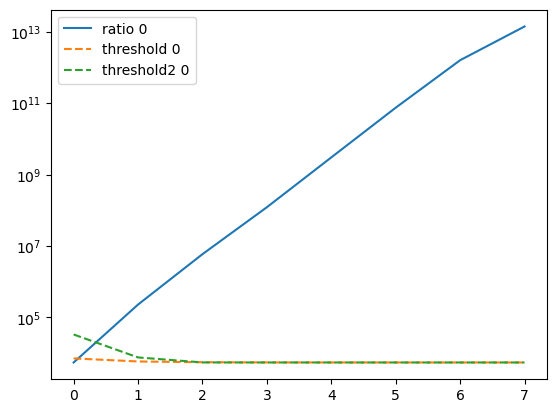

Noise level 	 order 	 	 ratio 	 	 threshold 	 threshold2
1e-10
6.47832922383616e-08
916.5330697663464 0.16795301629119608
C1: 916.5332960370437, C2: 5.962078358218031
	  	 2 	 	 5.457e+03 	 7.110e+03 	 3.328e+04
	  	 3 	 	 2.293e+05 	 5.836e+03 	 7.573e+03
	  	 4 	 	 5.921e+06 	 5.555e+03 	 5.479e+03
	  	 5 	 	 1.218e+08 	 5.506e+03 	 5.471e+03
	  	 6 	 	 4.945e+08 	 5.502e+03 	 5.465e+03
	  	 7 	 	 3.309e+08 	 5.501e+03 	 5.472e+03
	  	 8 	 	 2.109e+08 	 5.501e+03 	 5.465e+03
	  	 9 	 	 1.251e+08 	 5.501e+03 	 5.487e+03


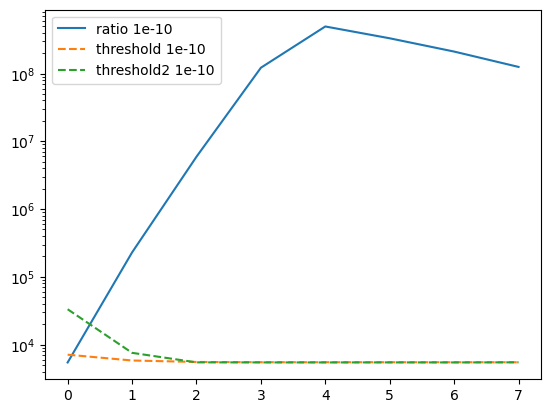

Noise level 	 order 	 	 ratio 	 	 threshold 	 threshold2
1e-09
6.464464435222896e-07
916.5330698259206 0.16795281868566161
C1: 916.5337980909959, C2: 5.979983073118421
	  	 2 	 	 5.457e+03 	 7.140e+03 	 3.347e+04
	  	 3 	 	 2.293e+05 	 5.871e+03 	 7.613e+03
	  	 4 	 	 5.905e+06 	 5.625e+03 	 5.498e+03
	  	 5 	 	 5.249e+07 	 5.600e+03 	 5.514e+03
	  	 6 	 	 4.584e+07 	 5.598e+03 	 5.484e+03
	  	 7 	 	 3.093e+07 	 5.598e+03 	 5.561e+03
	  	 8 	 	 1.995e+07 	 5.598e+03 	 5.484e+03
	  	 9 	 	 1.200e+07 	 5.598e+03 	 5.715e+03


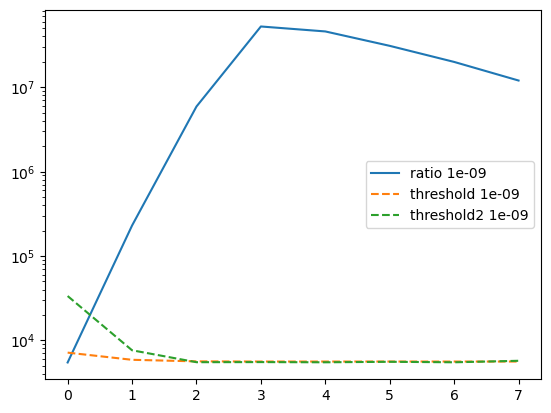

Noise level 	 order 	 	 ratio 	 	 threshold 	 threshold2
1e-08
6.511067898028155e-06
916.533070097063 0.16795352201725844
C1: 916.5352402183163, C2: 6.0319669845814685
	  	 2 	 	 5.457e+03 	 7.255e+03 	 3.402e+04
	  	 3 	 	 2.291e+05 	 6.064e+03 	 7.790e+03
	  	 4 	 	 4.706e+06 	 5.917e+03 	 5.567e+03
	  	 5 	 	 5.921e+06 	 5.908e+03 	 5.800e+03
	  	 6 	 	 4.823e+06 	 5.907e+03 	 5.557e+03
	  	 7 	 	 3.317e+06 	 5.907e+03 	 6.251e+03
	  	 8 	 	 2.186e+06 	 5.907e+03 	 5.561e+03
	  	 9 	 	 1.351e+06 	 5.907e+03 	 7.647e+03


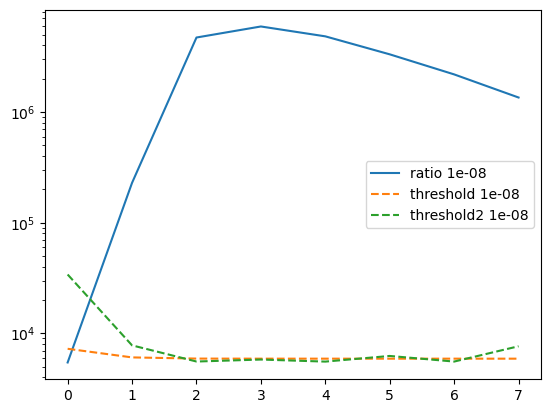

Noise level 	 order 	 	 ratio 	 	 threshold 	 threshold2
1e-07
6.386312917817264e-05
916.5330716045371 0.1679559035344507
C1: 916.5404666160555, C2: 6.2281666939155
	  	 2 	 	 5.457e+03 	 7.904e+03 	 3.626e+04
	  	 3 	 	 2.197e+05 	 7.035e+03 	 9.304e+03
	  	 4 	 	 7.891e+05 	 6.976e+03 	 6.015e+03
	  	 5 	 	 5.803e+05 	 6.973e+03 	 9.030e+03
	  	 6 	 	 4.526e+05 	 6.973e+03 	 6.065e+03
	  	 7 	 	 3.040e+05 	 6.973e+03 	 1.466e+04
	  	 8 	 	 1.973e+05 	 6.973e+03 	 6.113e+03
	  	 9 	 	 1.216e+05 	 6.973e+03 	 3.194e+04


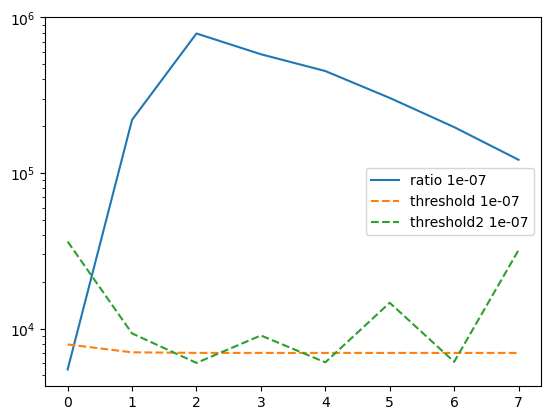

Noise level 	 order 	 	 ratio 	 	 threshold 	 threshold2
1e-06
0.0006487052529842442
916.5330032104571 0.16833865504142223
C1: 916.5558426059628, C2: 6.872887210495702
	  	 2 	 	 5.445e+03 	 1.167e+04 	 4.553e+04
	  	 3 	 	 7.346e+04 	 1.123e+04 	 2.416e+04
	  	 4 	 	 8.331e+04 	 1.121e+04 	 9.706e+03
	  	 5 	 	 6.100e+04 	 1.121e+04 	 4.485e+04
	  	 6 	 	 4.866e+04 	 1.121e+04 	 1.044e+04
	  	 7 	 	 3.288e+04 	 1.121e+04 	 1.102e+05
	  	 8 	 	 2.137e+04 	 1.121e+04 	 1.100e+04
	  	 9 	 	 1.306e+04 	 1.121e+04 	 3.110e+05


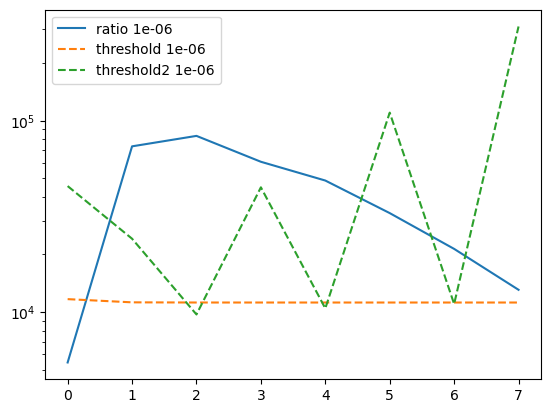

Noise level 	 order 	 	 ratio 	 	 threshold 	 threshold2
1e-05
0.00639905621275995
916.5327070177406 0.18330563073753137
C1: 916.6066086496063, C2: 9.140433716432478
	  	 2 	 	 5.000e+03 	 3.591e+04 	 1.156e+05
	  	 3 	 	 7.629e+03 	 3.565e+04 	 2.922e+05
	  	 4 	 	 7.759e+03 	 3.564e+04 	 7.115e+04
	  	 5 	 	 5.678e+03 	 3.564e+04 	 7.222e+05
	  	 6 	 	 4.462e+03 	 3.564e+04 	 8.506e+04
	  	 7 	 	 3.021e+03 	 3.564e+04 	 1.933e+06
	  	 8 	 	 1.959e+03 	 3.564e+04 	 9.551e+04
	  	 9 	 	 1.200e+03 	 3.564e+04 	 5.651e+06


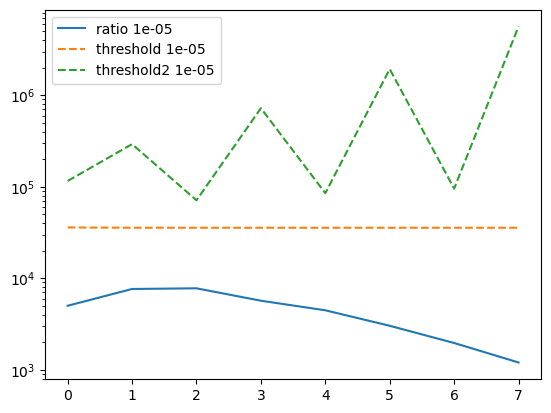

Noise level 	 order 	 	 ratio 	 	 threshold 	 threshold2
0.0001
0.06534987281453164
916.5216315626469 0.7322817103896098
C1: 916.7503888954, C2: 1.9860011638242736
	  	 2 	 	 1.252e+03 	 5.938e+03 	 2.383e+04
	  	 3 	 	 7.806e+02 	 5.934e+03 	 1.282e+05
	  	 4 	 	 8.281e+02 	 5.934e+03 	 3.021e+04
	  	 5 	 	 6.017e+02 	 5.934e+03 	 3.248e+05
	  	 6 	 	 4.775e+02 	 5.934e+03 	 3.651e+04
	  	 7 	 	 3.223e+02 	 5.934e+03 	 8.726e+05
	  	 8 	 	 2.091e+02 	 5.934e+03 	 4.124e+04
	  	 9 	 	 1.268e+02 	 5.934e+03 	 2.555e+06


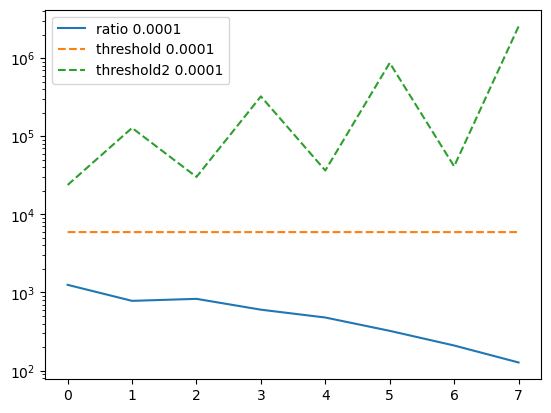

Noise level 	 order 	 	 ratio 	 	 threshold 	 threshold2
0.001
0.6471569690096731
916.5296354899442 7.063752804220244
C1: 917.2642486867426, C2: 0.15799935884292124
	  	 2 	 	 1.298e+02 	 2.269e+02 	 1.400e+03
	  	 3 	 	 7.768e+01 	 2.269e+02 	 8.385e+03
	  	 4 	 	 8.122e+01 	 2.269e+02 	 1.999e+03
	  	 5 	 	 5.914e+01 	 2.269e+02 	 2.124e+04
	  	 6 	 	 4.722e+01 	 2.269e+02 	 2.411e+03
	  	 7 	 	 3.251e+01 	 2.269e+02 	 5.701e+04
	  	 8 	 	 2.169e+01 	 2.269e+02 	 2.719e+03
	  	 9 	 	 1.356e+01 	 2.269e+02 	 1.669e+05


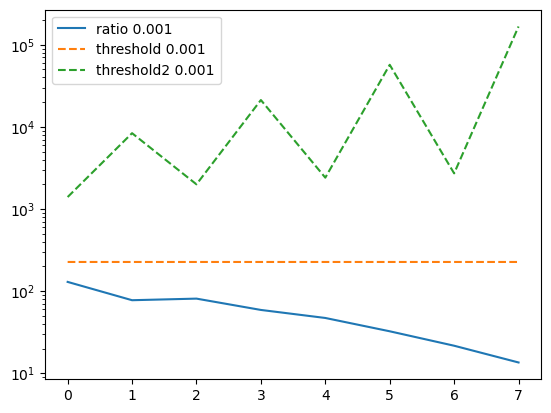

Noise level 	 order 	 	 ratio 	 	 threshold 	 threshold2
0.01
6.517509151827898
919.1879223528153 72.20018711080496
C1: 921.3793384319462, C2: 0.014283924503510691
	  	 2 	 	 1.273e+01 	 1.530e+01 	 1.039e+02
	  	 3 	 	 7.688e+00 	 1.530e+01 	 6.168e+02
	  	 4 	 	 7.982e+00 	 1.530e+01 	 1.490e+02
	  	 5 	 	 5.915e+00 	 1.530e+01 	 1.558e+03
	  	 6 	 	 4.782e+00 	 1.530e+01 	 1.792e+02
	  	 7 	 	 3.423e+00 	 1.530e+01 	 4.180e+03
	  	 8 	 	 2.578e+00 	 1.530e+01 	 2.018e+02
	  	 9 	 	 2.412e+00 	 1.530e+01 	 1.223e+04


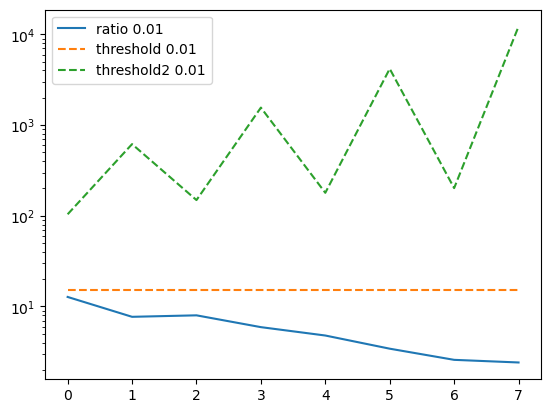

In [157]:
M=infinity_norm(uxxx)
number_noise=10 #<=10
noise_levels = [0]+[10**(-10+i) for i in range(0,number_noise-1)]
orders=range(2,10,1)
print(f"True ratio: {sv_max/sv_min:3.3e}")
unorm2=np.sqrt(np.mean(np.square(u)))


for target_noise in noise_levels:
    print("Noise level \t order \t \t ratio \t \t threshold \t threshold2")
    print(f"{target_noise}")
    
    threshold_list = []
    threshold2_list = []
    ratio_list=[]
    
    var = target_noise * unorm2
    noise = np.random.normal(0, var, size=u.shape)
    print(np.linalg.norm(noise))
    u_noise = u + noise
    eps_two = np.linalg.norm(u-u_noise)
    eps_infty = infinity_norm(u-u_noise)

    #Educated guess for C1 C2
    C1,C2 = educated_guess_c1c2(u_noise,eps_infty,dx)
    print(f"C1: {C1}, C2: {C2}")
    for order in orders:        
        ux_noise = ps.FiniteDifference(order=order,d=1, axis=0, drop_endpoints=False)._differentiate(u_noise, dx)
        u_flat_noise, u_x_flat_noise = u_noise.flatten(), ux_noise.flatten()
        g_noise = np.concatenate([u_flat_noise.reshape(len(u_flat_noise),1), u_x_flat_noise.reshape(len(u_flat_noise),1)], axis=1)
        sv = svd(g_noise, compute_uv=False)
        ratio=sv[0]/sv[-1]
        
        threshold = calc_threshold_uniq(C1,C2,eps_two,dx,order)
        threshold2 = calc_threshold_uniq2(C1,C2,eps_two,eps_infty,M,dx,true_g.shape[0],order)
        threshold_list.append(threshold)
        threshold2_list.append(threshold2)
        ratio_list.append(ratio)

        
        print(f"\t  \t {order} \t \t {ratio:3.3e} \t {threshold:3.3e} \t {threshold2:3.3e}")
    
    plt.plot(ratio_list,label=f'ratio {target_noise}')
    plt.plot(threshold_list,'--',label=f'threshold {target_noise}')
    plt.plot(threshold2_list,'--',label=f'threshold2 {target_noise}')
    plt.yscale('log')
    plt.legend()
    plt.show()